### Load the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import linear_model
from sklearn import neighbors 
from sklearn import svm 
from sklearn import tree
from sklearn import ensemble 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score
from scipy.special import logit
from scipy.special import expit 

In [2]:
# Define variables to be imported
risk_low = ['LIQ','CDS','GOVTBND']
risky = ['EQUITY','OBND']
demographics = ['AGE','EDCL','OCCAT1','MARRIED']
financials = ['INCOME','SAVING','NETWORTH']
goal = ['SAVRES1','SAVRES2','SAVRES3','SAVRES4','SAVRES5','SAVRES6','SAVRES7','SAVRES8','SAVRES9']

In [3]:
# Import data from working directory 
data = pd.read_csv('SCFP2019.csv', usecols=demographics+financials+goal+risk_low+risky)

#### Define dependent variable 

In [4]:
# Inspecting respondents with no investments
data.loc[(data[risk_low+risky].sum(axis=1)==0)].shape[0]

389

389 respondents were neither invested in risk-low or risky assets.  
Only active investors will be retained to assess risk tolerance.

In [5]:
# Filter out non-investors 
data.drop(data.loc[(data[risk_low+risky].sum(axis=1)==0)].index,inplace=True)
data.loc[(data[risk_low+risky].sum(axis=1)==0)].shape[0]

0

In [6]:
# Prepare dependent variable 
total_risky_assets = data[risky].sum(axis=1)
total_investment = data[risk_low+risky].sum(axis=1)
risk_tolerance = total_risky_assets/total_investment 
data['Risk Tolerance'] = risk_tolerance

### Exploratory analysis

#### Descriptive statistics

In [7]:
data.shape

(28496, 22)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28496 entries, 0 to 28884
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AGE             28496 non-null  int64  
 1   EDCL            28496 non-null  int64  
 2   MARRIED         28496 non-null  int64  
 3   OCCAT1          28496 non-null  int64  
 4   INCOME          28496 non-null  float64
 5   SAVRES1         28496 non-null  int64  
 6   SAVRES2         28496 non-null  int64  
 7   SAVRES3         28496 non-null  int64  
 8   SAVRES4         28496 non-null  int64  
 9   SAVRES5         28496 non-null  int64  
 10  SAVRES6         28496 non-null  int64  
 11  SAVRES7         28496 non-null  int64  
 12  SAVRES8         28496 non-null  int64  
 13  SAVRES9         28496 non-null  int64  
 14  SAVING          28496 non-null  int64  
 15  LIQ             28496 non-null  int64  
 16  CDS             28496 non-null  int64  
 17  GOVTBND         28496 non-null 

In [9]:
# SAVRES was imported as one hot encoded; converting back to categorical to simplify analysis
data['Invest_goal']=data.filter(like='SAVRES').idxmax(axis=1)
# Drop one hot encoded variables 
data.drop(data.filter(like='SAVRES').columns, axis=1, inplace=True)
# Adjust variable types of categories
data[demographics[1:]+['Invest_goal']] = data[demographics[1:]+['Invest_goal']].astype('category')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28496 entries, 0 to 28884
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   AGE             28496 non-null  int64   
 1   EDCL            28496 non-null  category
 2   MARRIED         28496 non-null  category
 3   OCCAT1          28496 non-null  category
 4   INCOME          28496 non-null  float64 
 5   SAVING          28496 non-null  int64   
 6   LIQ             28496 non-null  int64   
 7   CDS             28496 non-null  int64   
 8   GOVTBND         28496 non-null  int64   
 9   OBND            28496 non-null  int64   
 10  EQUITY          28496 non-null  float64 
 11  NETWORTH        28496 non-null  float64 
 12  Risk Tolerance  28496 non-null  float64 
 13  Invest_goal     28496 non-null  category
dtypes: category(4), float64(4), int64(6)
memory usage: 2.5 MB


There are no missing values and variable types are accurate.

In [11]:
data.head()

AGE EDCL MARRIED OCCAT1        INCOME  SAVING   LIQ    CDS  GOVTBND  \
0   75    4       2      1  67195.781504       0  6000  25000    84000   
1   75    4       2      1  57014.602488       0  6000  29000    63000   
2   75    4       2      1  51924.012980       0  6000  29000    94000   
3   75    4       2      1  41742.833964       0  6000  28000   259000   
4   75    4       2      1  50905.895078       0  6000  27000    50000   

     OBND    EQUITY   NETWORTH  Risk Tolerance Invest_goal  
0       0  409900.0  2153600.0        0.780911     SAVRES1  
1  177000  253000.0  2116200.0        0.814394     SAVRES1  
2       0  236550.0  2145000.0        0.647107     SAVRES1  
3  295000  403600.0  2552500.0        0.704518     SAVRES1  
4       0  259000.0  2176200.0        0.757310     SAVRES1

In [12]:
data.describe().apply(lambda s: s.apply('{0:.5f}'.format))

AGE           INCOME          SAVING              LIQ  \
count  28496.00000      28496.00000     28496.00000      28496.00000   
mean      53.28425     983607.65663     57977.60226     363845.27632   
std       16.22578   10256750.18634    516736.99779    3106840.08251   
min       18.00000          0.00000         0.00000          0.00000   
25%       41.00000      37670.36236         0.00000       1700.00000   
50%       54.00000      81449.43213        40.00000      10500.00000   
75%       65.00000     203623.58031     10000.00000      66000.00000   
max       95.00000  703590738.24000  28000000.00000  123554400.00000   

                  CDS         GOVTBND            OBND            EQUITY  \
count     28496.00000     28496.00000     28496.00000       28496.00000   
mean      55837.74354     18195.48252     39980.87240     3084348.14338   
std      784112.65827    479870.99042   1012901.21202    23980228.47708   
min           0.00000         0.00000         0.00000           0.00000   
25%           0.00000         0.00000         0.00000           0.00000   
50%           0.00000         0.00000         0.00000       10400.00000   
75%           0.00000         0.00000         0.00000      299000.00000   
max    49410000.00000  40920000.00000  63840000.00000  1257610000.00000   

               NETWORTH Risk Tolerance  
count       28496.00000    28496.00000  
mean     13641517.06076        0.43358  
std      78888556.07531        0.40840  
min       -955500.00000        0.00000  
25%         24450.00000        0.00000  
50%        244400.00000        0.41272  
75%       1672300.00000        0.86750  
max    1967199000.00000        1.00000

**Observations:**
- SAVRES variable was already one hot encoded when imported.
- There are a few categorical variables that need to be transformed to numeric form.
- There are no missing values in dataset.
- The range between the 75th percentile and the maximum value is very large for all variables except age and risk tolerance; unwanted outliers may be present. 
- Scales largely differ among input variables. Rescaling numerical features may be worth considering. 

#### Data visualizations

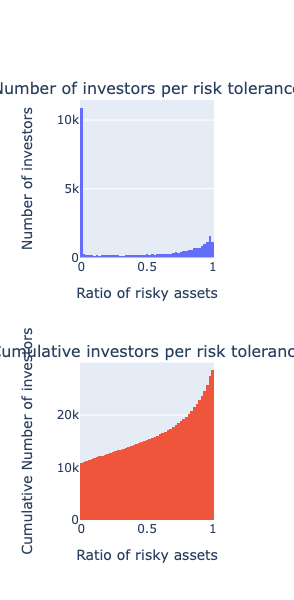

In [13]:
# Plotting distribution of risk tolerance 
fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=('Number of investors per risk tolerance','Cumulative investors per risk tolerance'))

fig.add_trace(
    go.Histogram(x=risk_tolerance, name='Number of investors'),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=risk_tolerance, cumulative_enabled=True, name= 'Cumulative investors'),
    row=2, col=1
)
fig.update_xaxes(title_text="Ratio of risky assets")
fig.update_yaxes(title_text="Number of investors", row=1, col=1)
fig.update_yaxes(title_text="Cumulative Number of investors", row=2, col=1)
fig.update_layout(showlegend=False,height=600, width=700)

fig.show()

**Observations:**
- Distribution of output variable resembles bimodal distribution. Models might benefit in normalizing output variable.
- Nearly one third of investors do not hold any risky assets.
- Approximately half of investors have equal amounts invested in risk-low and risky assets. 
- 3.6% are risk-seeking investors holding a portfolio with only risky investments.

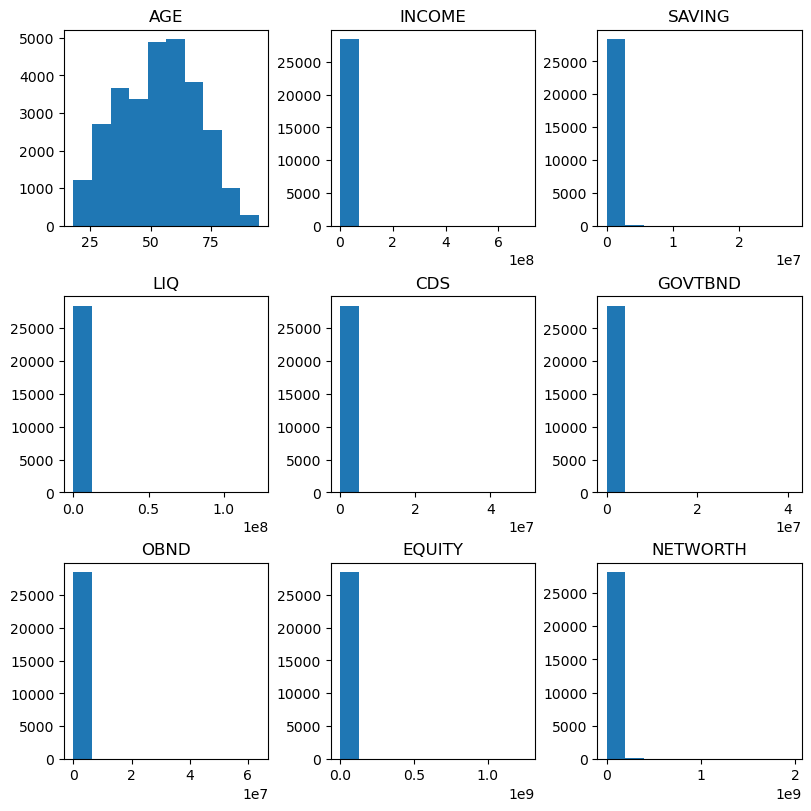

In [14]:
# Plot distribution of input variables
plt.figure(figsize=(8,8), layout='constrained')
for i in enumerate(data.select_dtypes('number').drop('Risk Tolerance',axis=1)):
    plt.subplot(3,3,i[0]+1)
    plt.hist(data[i[1]])
    plt.title(i[1])

plt.show()
    

**Observations:**
- Age is approximately normally distributed.
- All variables have outliers except Age and Risk tolerance. The variables with outliers are right skewed. Removal of skewness should be considered to improve model performance. 

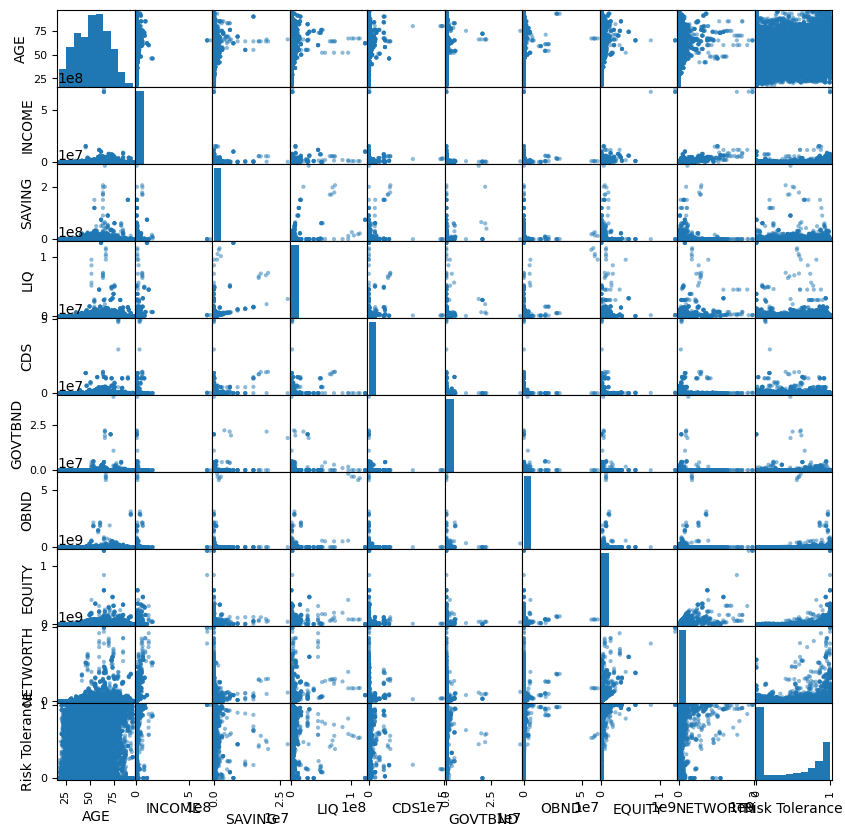

In [15]:
# Scatter matrix 
pd.plotting.scatter_matrix(data, figsize=(10,10))
plt.show()

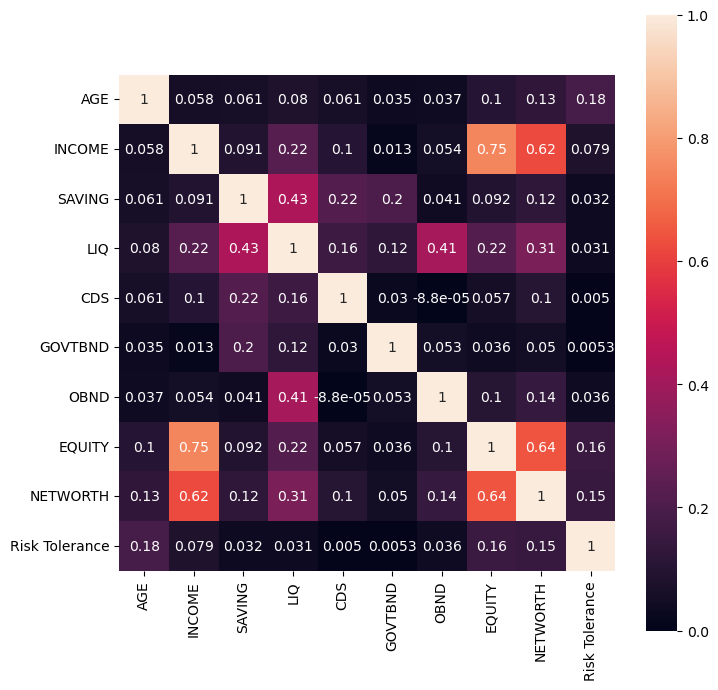

In [16]:
# Correlation matrix 
plt.figure(figsize=(8,8))
corr_matrix = data.corr(numeric_only=True)
sns.heatmap(corr_matrix,annot=True, square=True)
plt.show()

**Observations:**
- No significant correlation between input variables (moderate correlation between income and equity+net worth).  
Multicollinearity should not be an issue. 
- No strong linear relationship between input variables and output variable. 
- It is expected that non-linear models will outperform linear models without data transforms.  

### Data pre-processing

#### Convert categorical variables

All categorical variables need to be converted to numeric format before modeling. As linear regression model will be considered, all categorical variables will be encoded in K-1 classes, where K = Number of classes. 

In [17]:
# Dummy encode categorical variables 
clean_data = pd.get_dummies(data, columns=['EDCL','MARRIED','OCCAT1','Invest_goal'], drop_first=True)

In [18]:
clean_data.T

0             1             2             3      \
AGE                  7.500000e+01  7.500000e+01  7.500000e+01  7.500000e+01   
INCOME               6.719578e+04  5.701460e+04  5.192401e+04  4.174283e+04   
SAVING               0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
LIQ                  6.000000e+03  6.000000e+03  6.000000e+03  6.000000e+03   
CDS                  2.500000e+04  2.900000e+04  2.900000e+04  2.800000e+04   
GOVTBND              8.400000e+04  6.300000e+04  9.400000e+04  2.590000e+05   
OBND                 0.000000e+00  1.770000e+05  0.000000e+00  2.950000e+05   
EQUITY               4.099000e+05  2.530000e+05  2.365500e+05  4.036000e+05   
NETWORTH             2.153600e+06  2.116200e+06  2.145000e+06  2.552500e+06   
Risk Tolerance       7.809106e-01  8.143939e-01  6.471071e-01  7.045180e-01   
EDCL_2               0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
EDCL_3               0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
EDCL_4               1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
MARRIED_2            1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
OCCAT1_2             0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
OCCAT1_3             0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
OCCAT1_4             0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
Invest_goal_SAVRES2  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
Invest_goal_SAVRES3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
Invest_goal_SAVRES4  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
Invest_goal_SAVRES5  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
Invest_goal_SAVRES6  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
Invest_goal_SAVRES7  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
Invest_goal_SAVRES8  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
Invest_goal_SAVRES9  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                            4            5             6            7      \
AGE                  7.500000e+01     50.00000     50.000000     50.00000   
INCOME               5.090590e+04  38688.48026  37670.362358  38688.48026   
SAVING               0.000000e+00     10.00000     10.000000      5.00000   
LIQ                  6.000000e+03   1590.00000   1590.000000   1585.00000   
CDS                  2.700000e+04      0.00000      0.000000      0.00000   
GOVTBND              5.000000e+04      0.00000      0.000000      0.00000   
OBND                 0.000000e+00      0.00000      0.000000      0.00000   
EQUITY               2.590000e+05      0.00000      0.000000      0.00000   
NETWORTH             2.176200e+06  -6710.00000  -4710.000000  -8115.00000   
Risk Tolerance       7.573099e-01      0.00000      0.000000      0.00000   
EDCL_2               0.000000e+00      1.00000      1.000000      1.00000   
EDCL_3               0.000000e+00      0.00000      0.000000      0.00000   
EDCL_4               1.000000e+00      0.00000      0.000000      0.00000   
MARRIED_2            1.000000e+00      0.00000      0.000000      0.00000   
OCCAT1_2             0.000000e+00      0.00000      0.000000      0.00000   
OCCAT1_3             0.000000e+00      0.00000      0.000000      0.00000   
OCCAT1_4             0.000000e+00      1.00000      1.000000      1.00000   
Invest_goal_SAVRES2  0.000000e+00      0.00000      0.000000      0.00000   
Invest_goal_SAVRES3  0.000000e+00      0.00000      0.000000      0.00000   
Invest_goal_SAVRES4  0.000000e+00      0.00000      0.000000      0.00000   
Invest_goal_SAVRES5  0.000000e+00      0.00000      0.000000      0.00000   
Invest_goal_SAVRES6  0.000000e+00      0.00000      0.000000      0.00000   
Invest_goal_SAVRES7  0.000000e+00      1.00000      1.000000      1.00000   
Invest_goal_SAVRES8  0.000000e+00      0.00000      0.000000      0.00000   
Invest_goal_SAVRES9  0.000000e+00      0.00000  

#### Logit transform output variable

The continuous output variable ranges between 0 and 1. However, it is not guaranteed that predictions are within range. Logit transform will be applied on output variable and reverse logit used to convert predictions and make sure that each prediction lies between 0 and 1. 

In [19]:
# Apply logit transform to output variable as it ranges from 0 to 1 and range is not guaranteed by predictions 
# Reverse logit will be applied on predictions 
clean_data.loc[clean_data['Risk Tolerance'] == 0, 'Risk Tolerance'] = clean_data.loc[clean_data['Risk Tolerance'] == 0, 'Risk Tolerance']+0.001

In [20]:
clean_data.loc[clean_data['Risk Tolerance']==1, 'Risk Tolerance'] = clean_data.loc[clean_data['Risk Tolerance']==1, 'Risk Tolerance']-0.001

In [21]:
(clean_data['Risk Tolerance']==1).sum()

0

### Model evaluation

In [22]:
# Split dependent and independent variables 
Y = np.array(clean_data['Risk Tolerance'])
X = np.array(clean_data.drop('Risk Tolerance',axis=1))

In [23]:
X.shape

(28496, 24)

In [24]:
# Hold back 20% validation set to confirm accuracy of final model 
validation_size = 0.20
seed = 1
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

#### Baseline models

In [25]:
# Define baseline models 
models = []
models.append(('LR', linear_model.LinearRegression()))
models.append(('Lasso', linear_model.Lasso()))
models.append(('EN', linear_model.ElasticNet()))
models.append(('KNN', neighbors.KNeighborsRegressor()))
models.append(('Tree', tree.DecisionTreeRegressor()))
models.append(('SVR', svm.SVR()))

In [26]:
# Train and test each model with 10-fold cross validation
# Evaluate with R-squared
# May take a few minutes to run 
scores = []
names = []
predictions = []
for name, model in models:
    cval = model_selection.KFold(n_splits=10)
    regr = TransformedTargetRegressor(regressor=model,func=logit,inverse_func=expit)
    cval_pred = model_selection.cross_val_predict(regr,X_train,Y_train,cv=cval)
    cval_results = model_selection.cross_val_score(regr,X_train,Y_train,cv=cval,scoring='explained_variance')
    scores.append(cval_results)
    names.append(name)
    predictions.append(cval_pred)
    print(f'{name}: {cval_results.mean()}, ({cval_results.std()})')

LR: 0.18521965137630153, (0.027455429247509683)
Lasso: 0.06319064185561178, (0.008921613567179782)
EN: 0.09825383291576313, (0.010075392981578474)
KNN: 0.8649493370177878, (0.013182459934494876)
Tree: 0.9967546936040698, (0.0011125942379440112)
SVR: 0.21341527124509985, (0.0151022484225057)


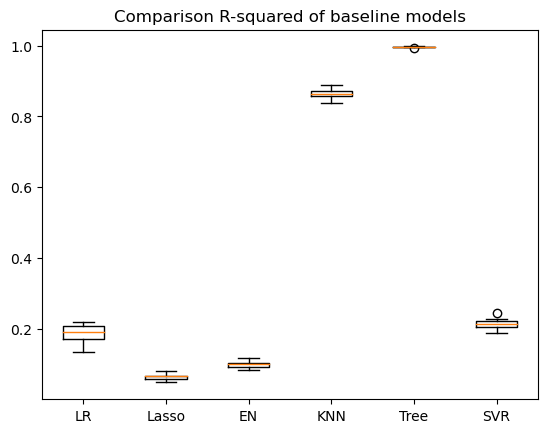

In [27]:
# Plot performances of baseline models 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)
ax.set_title(f'Comparison R-squared of baseline models')
plt.show()

**Observations:**
- As expected, non-linear models largely outperformed linear models. 
- Especially decision tree with consistently high accuracy accross folds. 

**Next, data transformations will be applied to reduce high bias of linear models.**

#### Models with data transformation

In order to improve model performance, input variables will be standardized and the skewness in distributions will be reduced. 

In [28]:
# Check if all variables are strictly positive 
(clean_data.drop('Risk Tolerance',axis=1).select_dtypes(exclude='uint8') <= 0).sum()

AGE             0
INCOME        190
SAVING      13621
LIQ            50
CDS         25745
GOVTBND     28219
OBND        28081
EQUITY      10771
NETWORTH     2498
dtype: int64

As some variables have 0 and negative values, Yeo Johnson transform will be used instead of Box Cox transform to remove skewness.

In [29]:
# Define transforms to be applied on numeric input variables
X_train = pd.DataFrame(X_train, columns = clean_data.drop('Risk Tolerance',axis=1).columns) # convert to dataframe to filter data types below
numeric_cols = clean_data.drop('Risk Tolerance',axis=1).select_dtypes(exclude='uint8').columns
t = [('skew',PowerTransformer(method='yeo-johnson'),numeric_cols)] # 
transformers = ColumnTransformer(transformers=t, remainder='passthrough')

# Define pipelines including transforms and model
pipelines = []
pipelines.append(('TransformedLR', Pipeline(steps=[('prep',transformers), ('LR', linear_model.LinearRegression())])))
pipelines.append(('TransformedLasso', Pipeline(steps=[('prep',transformers), ('Lasso', linear_model.Lasso())])))
pipelines.append(('TransformedEN', Pipeline(steps=[('prep',transformers), ('EN', linear_model.ElasticNet())])))
pipelines.append(('TransformedKNN', Pipeline(steps=[('prep',transformers), ('KNN', neighbors.KNeighborsRegressor())])))
pipelines.append(('TransformedTREE', Pipeline(steps=[('prep',transformers), ('Tree', tree.DecisionTreeRegressor())])))
pipelines.append(('TransformedSVR', Pipeline(steps=[('prep',transformers), ('SVR', svm.SVR())])))

scores_transform = []
names_tranform = []
new_pred = []
for name,model in pipelines:
    cval = model_selection.KFold(n_splits=10)
    regr = TransformedTargetRegressor(regressor=model,func=logit,inverse_func=expit)
    cval_pred = model_selection.cross_val_predict(regr,X_train,Y_train,cv=cval)
    cval_results = model_selection.cross_val_score(regr,X_train,Y_train,cv=cval,scoring='explained_variance')
    scores_transform.append(cval_results)
    names_tranform.append(name)
    new_pred.append(cval_pred)
    print(f'{name}: {cval_results.mean()}, ({cval_results.std()})')

TransformedLR: 0.9461068359524389, (0.0029802216993674953)
TransformedLasso: 0.7196585096195937, (0.007234479267613056)
TransformedEN: 0.6812249032137105, (0.007159396603584575)
TransformedKNN: 0.9310235982599524, (0.007449895232205798)
TransformedTREE: 0.996865283710062, (0.0008236474600459904)
TransformedSVR: 0.9889288622190653, (0.0015476558524065763)


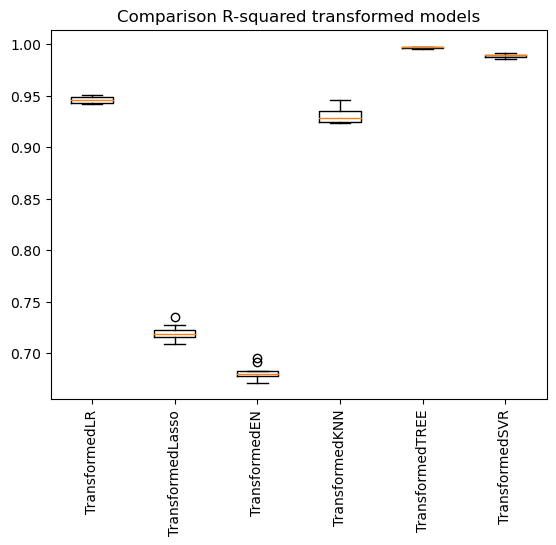

In [30]:
# Plot performances of tranformed models 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(scores_transform)
ax.set_xticklabels(names_tranform, rotation=90)
ax.set_title('Comparison R-squared transformed models')
plt.show()

### Finalize model

As the decision tree algorithm shows very good and stable performance over test folds, it will be chosen as the final model to be tested on the validation set. Also, it is a more or less transparent algorithm, which allows to explain to investors and regulators how the risk score was defined. 

In [31]:
# Prepare retained model

# Fit and apply transforms on training data 
t = [('scaler', StandardScaler(), numeric_cols),('skew',PowerTransformer(method='yeo-johnson'),numeric_cols)]
transformer = ColumnTransformer(transformers=t, remainder='passthrough')
fitted_transform = transformer.fit(X_train)
Xtrain_transformed = fitted_transform.transform(X_train)

# Prepare and fit model
model = tree.DecisionTreeRegressor()
wrapped_model = TransformedTargetRegressor(regressor=model,func=logit,inverse_func=expit)
wrapped_model.fit(Xtrain_transformed, Y_train)

# Apply fitted transform on validation set (avoids data leakage)
X_validation = pd.DataFrame(X_validation, columns = clean_data.drop('Risk Tolerance',axis=1).columns) # that numeric cols can be filtered
Xvalidation_transformed = fitted_transform.transform(X_validation)

# Predict validation set 
predictions = wrapped_model.predict(Xvalidation_transformed)
print(f'Score of retained model on validation set: {r2_score(Y_validation,predictions)}')

Score of retained model on validation set: 0.9976541011906032


The model's good performance is confirmed by valdiation set. 

In [32]:
# Save model and data preperations for future use 
from pickle import dump
from pickle import load 

dump(wrapped_model, open('DecisionTree_Ytransform.pkl','wb'))
dump(fitted_transform, open('Standardized_Unskewed_Transformer.pkl','wb'))

### References
Federal Reserve , 2022. Survey of Consumer Finances (SCF). [Online] 
Available at: https://www.federalreserve.gov/econres/scfindex.htm

Grable, J. E., 2020. How Reliable Is Your Risk-Tolerance Questionnaire?. Journal of Financial Service Professionals, 74(3), pp. 10-14.

Lucarelli, C., Uberti, P. & Brighetti, G., 2015. Misclassifications in financial risk tolerance. Journal of Risk Research, 18(4), pp. 467-482.

Yook, K. C. & Everett, R., 2003. Assessing risk tolerance: Questioning the questionnaire method. Journal of Financial Planning, 16(8), p. 48.